## Library

In [1]:
!pip install gpytorch
!pip install wandb

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import cv2
from tqdm import tqdm
from skimage.transform import resize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import v2 as transforms

import wandb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy

from torch.cpu.amp import GradScaler

import time

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [3]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## Init GPU

In [4]:
# Initialize GPU Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

print(device)

GPU: NVIDIA GeForce RTX 4070 SUPER is available.
cuda


In [5]:
%load_ext autoreload
%autoreload 2

## Seed Everything

In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

## Config Info

In [7]:
# Constants
HEIGHT = 224
WIDTH = 224
CHANNELS = 1

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
TEST_BATCH_SIZE = 2
TEST_SIZE = 0.15
VALID_SIZE = 0.15

MAX_SLICES = 60
SHAPE = (HEIGHT, WIDTH, CHANNELS)

NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
INDUCING_POINTS = 128
THRESHOLD = 0.4

# TARGET_LABELS = ['any', 'epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
TARGET_LABELS = ['intraparenchymal']

MODEL_PATH = 'results/trained_model.pth'
DEVICE = 'cuda'

In [8]:
# Kaggle and local switch
KAGGLE = os.path.exists('/kaggle')
print("Running on Kaggle" if KAGGLE else "Running locally")
ROOT_DIR = '/kaggle/input/rsna-mil-training/' if KAGGLE else None
# DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-mil-training/'
DATA_DIR = ROOT_DIR + 'rsna-mil-training/' if KAGGLE else '../rsna-ich-mil/'
DICOM_DIR = DATA_DIR
# CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_1000_scan_subset.csv'
CSV_PATH = DICOM_DIR + 'training_1000_scan_subset.csv' if KAGGLE else './data_analyze/training_dataset_2.csv'
# SLICE_LABEL_PATH = ROOT_DIR + "sorted_training_dataset_with_labels.csv" if KAGGLE else './data_analyze/sorted_training_dataset_with_labels.csv'

dicom_dir = DICOM_DIR if KAGGLE else DATA_DIR
# Load patient scan labels
# patient_scan_labels = pd.read_csv(CSV_PATH)
patient_scan_labels = pd.read_csv(CSV_PATH, nrows=1150)

# patient_slice_labels = pd.read_csv(SLICE_LABEL_PATH)
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

Running locally


In [9]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("Wandb key")
# 
# wandb.login(key=key, relogin=True)

In [10]:
patient_scan_labels.head()

,filename,labels,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,patient_id,study_instance_uid,image_position,samples_per_pixel,pixel_spacing,pixel_representation,window_center,window_width,rescale_intercept,rescale_slope,patient_label
0,"['ID_45785016b.dcm', 'ID_37f32aed2.dcm', 'ID_1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0002cd41,ID_66929e09d4,"['[-125.000, -122.596, 35.968]', '[-125.000, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.488281, 0.488281]', '[0.488281, 0.488281]...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['30', '30', '30', '30', '30', '30', '30', '30...","['80', '80', '80', '80', '80', '80', '80', '80...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
1,"['ID_138d275c8.dcm', 'ID_447fa09d9.dcm', 'ID_0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00054f3f,ID_8a449ae31b,"['[-111.5, -3.5, 71.9000244]', '[-111.5, -3.5,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.435546875, 0.435546875]', '[0.435546875, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","['[00036, 00036]', '[00036, 00036]', '[00036, ...","['[00080, 00080]', '[00080, 00080]', '[00080, ...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
2,"['ID_c6f9f68c9.dcm', 'ID_520df89aa.dcm', 'ID_b...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_0006d192,ID_25690b4725,"['[-125.000, -122.546, 38.171]', '[-125.000, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.488281, 0.488281]', '[0.488281, 0.488281]...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['40', '40', '40', '40', '40', '40', '40', '40...","['150', '150', '150', '150', '150', '150', '15...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
3,"['ID_31b14de96.dcm', 'ID_203ef1efe.dcm', 'ID_9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ID_00086119,ID_fdde2979b0,"['[-125.000, -120.158, 32.955]', '[-125.000, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['[0.488281, 0.488281]', '[0.488281, 0.488281]...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","['30', '30', '30', '30', '30', '30', '30', '30...","['80', '80', '80', '80', '80', '80', '80', '80...","[-1024.0, -1024.0, -1024.0, -1024.0, -1024.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0
4,"['ID_0785539ea.dcm', 'ID_30c100dbc.dcm', 'ID_3...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## Data Preprocessing

In [11]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def create_bone_mask(dcm):
    # Assuming dcm.pixel_array contains the HU values
    hu_values = dcm.pixel_array

    # Create a mask for bone regions
    # bone_mask = (hu_values >= 1000) & (hu_values <= 1200)
    bone_mask = (hu_values >= 1000) & (hu_values <= 1200)
    return bone_mask

def extract_bone_mask(dcm):
    # Create the bone mask
    bone_mask = create_bone_mask(dcm)

    # Extract the bone mask from the image
    hu_values = dcm.pixel_array.copy()
    # hu_values[bone_mask] = 0
    hu_values[~bone_mask] = 0

    # Update the DICOM pixel data
    dcm.PixelData = hu_values.tobytes()


def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    # extract_bone_mask(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept

    # Resize
    img = cv2.resize(img, SHAPE[:2], interpolation = cv2.INTER_LINEAR)

    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 90)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)

    brain_img = (brain_img - 0) / 90
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380

    if CHANNELS == 3:
        bsb_img = np.stack([brain_img, subdural_img, soft_img], axis=-1)
    else:
        bsb_img = brain_img
    return bsb_img.astype(np.float16)

In [12]:
def preprocess_slice(slice, target_size=(HEIGHT, WIDTH)):
    # Check if type of slice is dicom or an empty numpy array
    if (type(slice) == np.ndarray):
        slice = resize(slice, target_size, anti_aliasing=True)
        multichannel_slice = np.stack([slice, slice, slice], axis=-1)
        if CHANNELS == 3:
            return multichannel_slice.astype(np.float16)
        else:
            return slice.astype(np.float16)
    else:
        slice = bsb_window(slice)
        return slice.astype(np.float16)

In [13]:
def read_dicom_folder(folder_path, max_slices=MAX_SLICES):
    # Filter and sort DICOM files directly based on ImagePositionPatient
    dicom_files = sorted(
        [f for f in os.listdir(folder_path) if f.endswith(".dcm")],
        key=lambda f: float(pydicom.dcmread(os.path.join(folder_path, f)).ImagePositionPatient[2])
    )[:max_slices]

    # Read and store slices
    slices = [pydicom.dcmread(os.path.join(folder_path, f)) for f in dicom_files]

    # Pad with black images if necessary
    if len(slices) < max_slices:
        black_image = np.zeros_like(slices[0].pixel_array)
        slices += [black_image] * (max_slices - len(slices))

    return slices[:max_slices]


## Dataset and DataLoader

### Splitting the Dataset

In [14]:
def split_dataset(patient_scan_labels, test_size=TEST_SIZE, val_size=VALID_SIZE, random_state=42):
    # Extract the labels from the DataFrame
    labels = patient_scan_labels['patient_label']

    # First, split off the test set
    train_val_labels, test_labels = train_test_split(
        patient_scan_labels, 
        test_size=test_size, 
        stratify=labels, 
        random_state=random_state
    )

    # Calculate the validation size relative to the train_val set
    val_size_adjusted = val_size / (1 - test_size)

    # Split the train_val set into train and validation sets
    train_labels, val_labels = train_test_split(
        train_val_labels, 
        test_size=val_size_adjusted, 
        stratify=train_val_labels['patient_label'], 
        random_state=random_state
    )

    return train_labels, val_labels, test_labels

### Processing the Data

In [15]:
def process_patient_data(dicom_dir, row, num_instances=12, depth=5):
    patient_id = row['patient_id'].replace('ID_', '')
    study_instance_uid = row['study_instance_uid'].replace('ID_', '')

    folder_name = f"{patient_id}_{study_instance_uid}"
    folder_path = os.path.join(dicom_dir, folder_name)

    if os.path.exists(folder_path):
        slices = read_dicom_folder(folder_path)

        preprocessed_slices = [torch.tensor(preprocess_slice(slice), dtype=torch.float32) for slice in slices]  # Convert to tensor

        # Stack preprocessed slices into an array
        preprocessed_slices = torch.stack(preprocessed_slices, dim=0)  # (num_slices, height, width, channels)

        # Labels are already in list form, so just convert them to a tensor
        labels = torch.tensor(row['labels'], dtype=torch.long)

        # Fill labels with 0s if necessary
        if len(preprocessed_slices) > len(labels):
            padded_labels = torch.zeros(len(preprocessed_slices), dtype=torch.long)
            padded_labels[:len(labels)] = labels
        else:
            padded_labels = labels[:len(preprocessed_slices)]

        return preprocessed_slices, padded_labels

    else:
        print(f"Folder not found: {folder_name}")
        return None, None

### Augmentation

In [16]:
class DatasetAugmentor:
    def __init__(self, height, width, levels=2, seed=None):
        self.height = height
        self.width = width
        self.levels = levels  # Dynamic number of levels
        self.seed = seed
        self.params = []

        # Create different levels of transforms based on the number of levels specified
        for i in range(levels):
            factor = (i + 1) / levels
            self.params.append(
                self._create_transform(
                    degrees=int(15 * factor), 
                    translate_range=(0.2 * factor, 0.2 * factor),
                    scale_range=(1 - 0.2 * factor, 1 + 0.2 * factor),
                    brightness_range=0.2 * factor,
                    contrast_range=0.2 * factor,
                    blur_sigma_range=(0.5 * factor, 1.0 * factor),
                    apply_elastic=(i >= levels // 2),
                    level_name=f'level_{i + 1}'
                )
            )

    def _sample_value(self, value_range):
        if isinstance(value_range, tuple):
            random.seed(self.seed)
            return random.uniform(value_range[0], value_range[1])
        return value_range

    def _create_transform(self, degrees, translate_range, scale_range, brightness_range, contrast_range, blur_sigma_range, apply_elastic, level_name):
        print(f"Creating '{level_name}' transform with parameters:")
        sampled_values = {
            "degrees": abs(self._sample_value((-degrees, degrees))),
            "translate": (abs(self._sample_value(translate_range[0])), abs(self._sample_value(translate_range[1]))),
            "scale": self._sample_value(scale_range),
            "brightness": self._sample_value(brightness_range),
            "contrast": self._sample_value(contrast_range),
            "blur_sigma": self._sample_value(blur_sigma_range),
            "apply_elastic": apply_elastic
        }
        
        print(sampled_values)
        return sampled_values

    def apply_transform(self, image, level):
        params = self.params[level]
        transform = self._get_transform(params, channels=image.shape[0])
        return transform(image)

    def _get_transform(self, params, channels=3):
        transform_list = [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomAffine(degrees=params["degrees"], translate=params["translate"], scale=(params["scale"], params["scale"])),
            transforms.ColorJitter(brightness=params["brightness"], contrast=params["contrast"]),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=params["blur_sigma"]),
            transforms.RandomApply([transforms.ElasticTransform()] if params["apply_elastic"] else [], p=0.3),
            transforms.Resize(256),
            transforms.CenterCrop(self.height),
            transforms.ToTensor(),
        ]

        if channels == 3:
            transform_list.extend([
                transforms.Normalize(mean=[0.16774411, 0.1360026, 0.19076315], std=[0.3101935, 0.27605791, 0.30469988]),
                transforms.RandomApply([self._channel_shuffle], p=0.3)
            ])
        elif channels == 1:
            transform_list.append(transforms.Normalize(mean=[0.16774411], std=[0.3101935]))

        return transforms.Compose(transform_list)

    def _channel_shuffle(self, tensor):
        torch.manual_seed(self.seed)
        channels = tensor.shape[0]
        indices = torch.randperm(channels)
        return tensor[indices]

In [17]:
augmentor = DatasetAugmentor(224, 224, seed=42)

Creating 'level_1' transform with parameters:
{'degrees': 1.9519751784103718, 'translate': (0.1, 0.1), 'scale': 1.027885359691577, 'brightness': 0.1, 'contrast': 0.1, 'blur_sigma': 0.4098566996144709, 'apply_elastic': False}
Creating 'level_2' transform with parameters:
{'degrees': 4.182803953736514, 'translate': (0.2, 0.2), 'scale': 1.0557707193831534, 'brightness': 0.2, 'contrast': 0.2, 'blur_sigma': 0.8197133992289418, 'apply_elastic': True}


### Dataset Generator

In [18]:
# class MedicalScanDataset(Dataset):
#     def __init__(self, data_dir, patient_scan_labels, augmentor=None):
#         self.data_dir = data_dir
#         self.patient_scan_labels = self._parse_patient_scan_labels(patient_scan_labels)
#         self.augmentor = augmentor
#
#     def _parse_patient_scan_labels(self, patient_scan_labels):
#         """Parse and validate patient scan labels."""
#         patient_scan_labels['images'] = patient_scan_labels['images'].apply(
#             lambda x: eval(x) if isinstance(x, str) else x
#         )
#         patient_scan_labels['labels'] = patient_scan_labels['labels'].apply(
#             lambda x: eval(x) if isinstance(x, str) else x
#         )
#         patient_scan_labels['patient_label'] = patient_scan_labels['patient_label'].astype(bool)
#         return patient_scan_labels
#
#     def _process_patient_data(self, row):
#         """Process patient data to get preprocessed slices and labels."""
#         return process_patient_data(self.data_dir, row)
#
#     def __len__(self):
#         return len(self.patient_scan_labels) * (self.augmentor.levels if self.augmentor else 1)
#
#     def __getitem__(self, idx):
#         patient_idx = idx // (self.augmentor.levels if self.augmentor else 1)
#         aug_level = idx % (self.augmentor.levels if self.augmentor else 1)
#
#         row = self.patient_scan_labels.iloc[patient_idx]
#         preprocessed_slices, labels = self._process_patient_data(row)
#
#         if preprocessed_slices is None:
#             return None, None, None
#
#         preprocessed_slices = self._prepare_tensor(preprocessed_slices, aug_level if self.augmentor else None)
#         patient_label = torch.tensor(bool(row['patient_label']), dtype=torch.uint8)
#
#         return preprocessed_slices, labels, patient_label
#
#     def _prepare_tensor(self, preprocessed_slices, aug_level):
#         # Convert to numpy array and then to torch tensor
#         preprocessed_slices = np.array(preprocessed_slices)
#         preprocessed_slices = torch.tensor(preprocessed_slices, dtype=torch.float32)
#
#         # Add an additional dimension for channel if it's missing (no augmentor)
#         if preprocessed_slices.ndim == 3:
#             preprocessed_slices = preprocessed_slices.unsqueeze(1)  # shape: [slices, 1, H, W]
#
#         # Apply augmentation if augmentor is specified
#         if self.augmentor and aug_level is not None:
#             if preprocessed_slices.ndim == 4:  # Ensure it has the [slices, channels, H, W] format
#                 return torch.stack([self.augmentor.apply_transform(img, aug_level) for img in preprocessed_slices])
#
#         return preprocessed_slices  # Return without augmentation if augmentor is None

In [19]:
# Full Dataset
class MedicalScanDataset:
    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        self.data_dir = data_dir
        self.dataset = self._parse_patient_scan_labels(patient_scan_labels)
        self.augmentor = augmentor

    def _parse_patient_scan_labels(self, patient_scan_labels):
        """Parse and validate patient scan labels."""
        patient_scan_labels['filename'] = patient_scan_labels['filename'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        )
        patient_scan_labels['labels'] = patient_scan_labels['labels'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        )
        patient_scan_labels['patient_label'] = patient_scan_labels['patient_label'].astype(bool)
        return patient_scan_labels

    def _process_patient_data(self, row):
        """Process patient data to get preprocessed slices and labels."""
        return process_patient_data(self.data_dir, row)

    def __len__(self):
        return len(self.dataset) * (self.augmentor.levels if self.augmentor else 1)

    def __getitem__(self, idx):
        patient_idx = idx // (self.augmentor.levels if self.augmentor else 1)
        aug_level = idx % (self.augmentor.levels if self.augmentor else 1)

        row = self.dataset.iloc[patient_idx]
        preprocessed_slices, labels = self._process_patient_data(row)

        preprocessed_slices = self._prepare_tensor(preprocessed_slices, aug_level if self.augmentor else None)
        patient_label = torch.tensor(bool(row['patient_label']), dtype=torch.uint8)

        return preprocessed_slices, labels, patient_label

    def _prepare_tensor(self, preprocessed_slices, aug_level):
        # Convert to numpy array and then to torch tensor
        preprocessed_slices = np.array(preprocessed_slices)
        preprocessed_slices = torch.tensor(preprocessed_slices, dtype=torch.float32)

        # Add an additional dimension for channel if it's missing (no augmentor)
        if preprocessed_slices.ndim == 3:
            preprocessed_slices = preprocessed_slices.unsqueeze(1)  # shape: [slices, 1, H, W]

        # Apply augmentation if augmentor is specified
        if self.augmentor and aug_level is not None:
            if preprocessed_slices.ndim == 4:  # Ensure it has the [slices, channels, H, W] format
                return torch.stack([self.augmentor.apply_transform(img, aug_level) for img in preprocessed_slices])

        return preprocessed_slices  # Return without augmentation if augmentor is None


In [20]:
class TrainDatasetGenerator(MedicalScanDataset):
    """Dataset class for training medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)

class TestDatasetGenerator(MedicalScanDataset):
    """Dataset class for testing medical scan data."""
    def __init__(self, data_dir, patient_scan_labels, augmentor=None):
        super().__init__(data_dir, patient_scan_labels, augmentor)

In [21]:
original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)

In [22]:
len(original_dataset)

1150

In [23]:
x,y,z = original_dataset[0]
print(x.shape, y.shape, z.shape)

torch.Size([60, 1, 224, 224]) torch.Size([60]) torch.Size([])


In [24]:
# # Check if the returned data is valid
# if x is not None:
#     # Convert the tensor to a numpy array
#     x_np = x.numpy()
#
#     # Check the number of dimensions and squeeze if necessary
#     if x_np.ndim == 4:  # RGB images
#         # Plot each slice
#         fig, axes = plt.subplots(1, x_np.shape[0], figsize=(15, 5))
#         for i, ax in enumerate(axes):
#             ax.imshow(x_np[i].transpose(1, 2, 0))  # Convert CHW to HWC
#             ax.axis('off')
#         plt.show()
#     elif x_np.ndim == 3:  # Grayscale images
#         # Plot each slice
#         fig, axes = plt.subplots(1, x_np.shape[0], figsize=(15, 5))
#         for i, ax in enumerate(axes):
#             ax.imshow(x_np[i], cmap='gray')
#             ax.axis('off')
#         plt.show()
#     else:
#         raise ValueError(f"Unexpected number of dimensions: {x_np.ndim}")
# else:
#     print("No data available for this patient.")


In [25]:
def get_train_loader(dicom_dir, patient_scan_labels, batch_size=TRAIN_BATCH_SIZE):
    # original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=augmentor)
    original_dataset = TrainDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(original_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

def get_test_loader(dicom_dir, patient_scan_labels, batch_size=TEST_BATCH_SIZE):
    test_dataset = TestDatasetGenerator(dicom_dir, patient_scan_labels, augmentor=None)
    return DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

## NTXent Loss

In [26]:
# # Define NTXentLoss
# class NTXentLoss(nn.Module):
#     def __init__(self, temperature=0.5):
#         super(NTXentLoss, self).__init__()
#         self.temperature = temperature
#
#     def forward(self, z_i, z_j):
#         batch_size = z_i.size(0)
#         z = torch.cat([z_i, z_j], dim=0)
#         z = F.normalize(z, dim=1)
#         similarity_matrix = torch.mm(z, z.T) / self.temperature
#         mask = torch.eye(2 * batch_size, device=z.device).bool()
#         similarity_matrix.masked_fill_(mask, -float('inf'))
#         exp_sim = torch.exp(similarity_matrix)
#         denominator = exp_sim.sum(dim=1)
#         positive_samples = torch.cat(
#             [torch.arange(batch_size, 2 * batch_size), torch.arange(batch_size)], dim=0
#         ).to(z.device)
#         positives = similarity_matrix[torch.arange(2 * batch_size), positive_samples]
#         loss = -torch.log(torch.exp(positives) / denominator)
#         return loss.mean()

In [27]:
from pytorch_metric_learning import losses
import torch.nn.functional as F

# class NTXentLoss(losses.NTXentLoss):
#     def __init__(self, temperature, **kwargs):
#         super().__init__(temperature=temperature, **kwargs)
#         self.temperature = temperature
#
#     def forward(self, embeddings1, embeddings2, labels=None, hard_pairs=None):
#         # Concatenate the embeddings
#         embeddings = torch.cat([embeddings1, embeddings2], dim=0)
#         # Normalize feature vectors
#         feature_vectors_normalized = F.normalize(embeddings, p=2, dim=1)
#
#         if labels == None:
#             # Self-supervised labels
#             labels = torch.arange(feature_vectors_normalized.size(0))
#         else:
#             # Supervised labels
#             labels = torch.cat([labels, labels], dim=0)
#
#         # Compute logits
#         logits = torch.div(
#             torch.matmul(
#                 feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
#             ),
#             self.temperature,
#         )
#
#         if labels == None:
#             return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
#         if hard_pairs == None:
#             return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
#         return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels), hard_pairs)

class NTXentLoss(losses.NTXentLoss):
    def __init__(self, temperature, **kwargs):
        super().__init__(temperature=temperature, **kwargs)
        self.temperature = temperature

    def forward(self, embeddings, labels=None, hard_pairs=None):
        # Normalize feature vectors
        feature_vectors_normalized = F.normalize(embeddings, p=2, dim=1)

        if labels == None:
            # Self-supervised labels
            # labels = torch.arange(feature_vectors_normalized.size(0))
            batch_size = feature_vectors_normalized.size(0) // 2  # Assuming equal size for both embeddings
            labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)], dim=0)

        # Compute logits
        logits = torch.div(
            torch.matmul(
                feature_vectors_normalized, torch.transpose(feature_vectors_normalized, 0, 1)
            ),
            self.temperature,
        )

        if labels == None:
            return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        if hard_pairs == None:
            return losses.NTXentLoss(temperature=self.temperature)(logits, torch.squeeze(labels))
        return losses.SupConLoss(temperature=self.temperature)(logits, torch.squeeze(labels), hard_pairs)

## Augmentation For Contrastive Learning

In [28]:
# Version 2: Avg time taken: 0.05 seconds for 1 augmentation (w ResizedCrop)
def augment_batch(batch_images):
    batch_size, num_instances, channels, height, width = batch_images.shape

    # Define augmentation transformations using GPU-compatible operations
    aug_transform = transforms.Compose([
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.1)),
        # transforms.RandomRotation(degrees=(-5, 5)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4)], p=0.6),
        transforms.RandomHorizontalFlip(p=0.5),
    ])

    # Apply transformations directly on the tensor without converting to PIL
    augmented_batch = torch.empty_like(batch_images)  # Preallocate memory for augmented images

    for i in range(batch_size):
        for j in range(num_instances):
            # Apply the transformation directly to the tensor
            if CHANNELS == 1:
                augmented_batch[i, j] = aug_transform(batch_images[i, j])
            else:
                augmented_batch[i, j] = aug_transform(batch_images[i, j].permute(2, 0, 1)).permute(1, 2, 0)

    return augmented_batch.cuda()  # Move the augmented batch to GPU

## CNN Feature Extractor

### Attention Layer

In [29]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AttentionLayer, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.PReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        # x shape: (batch_size, num_instances, feature_dim)
        attention_weights = self.attention(x)
        weights = F.softmax(attention_weights, dim=1)

        return (x * weights).sum(dim=1), weights.squeeze(-1)

In [30]:
class GatedAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GatedAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.gate = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            # nn.Tanh(),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, x):
        # x shape: (batch_size, num_instances, input_dim)
        attention_weights = self.attention(x)
        gate_weights = torch.sigmoid(self.gate(x))
        
        weights = attention_weights * gate_weights
        weights = F.softmax(weights, dim=1)
        
        return (x * weights).sum(dim=1), weights.squeeze(-1)

### Gaussian Process

In [31]:
class GPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Dual-Stream MIL Model (DSMIL)

In [32]:
class FCLayer(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(FCLayer, self).__init__()
        self.fc = nn.Sequential(nn.Linear(input_dim, output_dim))
        
    def forward(self, x):
        return self.fc(x)
    
class InstanceClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(InstanceClassifier, self).__init__()
        self.features_extractor = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # self.features_extractor = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.features_extractor.conv1 = nn.Conv2d(CHANNELS, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features_extractor.fc = nn.Identity()
        
        self.fc = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        if CHANNELS == 1:
            batch_size, num_instances, C, H, W = x.shape
        else:
            batch_size, num_instances, H, W, C = x.shape
        x = x.view(batch_size * num_instances, C, H, W)
        
        instance_features = nn.Dropout(0.25)(self.features_extractor(x)).view(batch_size, num_instances, -1)
        classes = self.fc(instance_features)
        
        return instance_features, classes
    
class BagClassifier(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=128, dropout_v=0.2, non_linear=True, passing_v=False):
        super(BagClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        
        if non_linear:
            self.q = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh()
            )
        else:
            self.q = nn.Linear(input_dim, hidden_dim)
        
        if passing_v:
            self.v = nn.Sequential(
                nn.Dropout(dropout_v),
                nn.Linear(input_dim, input_dim),
                nn.ReLU()
            )
        else:
            self.v = nn.Identity()
            
        self.fc = FCLayer(input_dim, output_dim)
        
    def forward(self, features, classes):
        batch_size = features.size(0)
        num_instances = features.size(1)
        features_dim = features.size(2)
        
        combine_features = features.view(features.shape[0] * features.shape[1], -1)
        V = self.v(combine_features)
        Q = self.q(combine_features)
        assert V.shape[0] == Q.shape[0] == batch_size * num_instances, f'V: {V.shape}, Q: {Q.shape}'
        assert V.shape[1] == features_dim, f'V: {V.shape} should be [{batch_size * num_instances}, {features_dim}]'
        assert Q.shape[1] == self.hidden_dim, f'Q: {Q.shape} should be [{batch_size * num_instances}, {self.hidden_dim}]'
        
        # Get critical instance indices by squeezing classes
        critical_indices = classes.squeeze(-1).argmax(dim=1)
        assert critical_indices.shape[0] == batch_size, f'Critical indices: {critical_indices.shape}'

        # Gather features for each batch using critical instance indices
        m_features = features[torch.arange(batch_size).unsqueeze(1), critical_indices.unsqueeze(1)].squeeze()
        m_features = m_features.view(batch_size, -1)
        assert m_features.shape[0] == batch_size, f'M features: {m_features.shape} should be [{batch_size}, {features_dim}]'
        q_max = self.q(m_features)
        assert q_max.shape[0] == batch_size and q_max.shape[1] == self.hidden_dim, f'Q max: {q_max.shape} should be [{batch_size}, {self.hidden_dim}]'
        
        A = torch.mm(Q, q_max.mT)
        A = F.softmax(A / torch.sqrt(torch.tensor(Q.shape[-1]).float()), dim=0)
        assert A.shape[0] == batch_size * num_instances and A.shape[1] == batch_size, f'A: {A.shape} should be [{batch_size * num_instances}, {batch_size}]'
        
        B = torch.mm(A.T, V)
        assert B.shape[0] == batch_size and B.shape[1] == features_dim, f'B: {B.shape} should be [{batch_size}, {features_dim}]'
        
        B = B.view(1, B.shape[0], B.shape[1]) # Shape of B: [1, batch_size, features_dim]
        C = self.fc(B)
        C = C.view(1, -1) # Shape of C: [1, batch_size, 1] -> [1, batch_size]
        return C, A, B

### ResNet2D Model

In [33]:
class MILResNet18(nn.Module):
    def __init__(self):
        super(MILResNet18, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(in_channels=CHANNELS, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.resnet.fc = nn.Identity()

        # self.attention = AttentionLayer(input_dim=512, hidden_dim=512)
        self.attention = GatedAttention(input_dim=512, hidden_dim=512)

        self.classifier = nn.Linear(512 + 1, 1) 
        self.attention_classifier = nn.Linear(512, 1)
        self.dropout = nn.Dropout(0.4)
        
        inducing_points = torch.randn(32, 512)
        self.gp_layer = GPModel(inducing_points=inducing_points)
        
        self.projection_head = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        
    def forward(self, bags):
        if CHANNELS == 1:
            batch_size, num_instances, c, h, w = bags.size()
        else:
            batch_size, num_instances, h, w, c = bags.size()

        bags_flattened = bags.view(batch_size * num_instances, c, h, w)
        
        # # Version 1: CNN-ResNet + Att + GP
        features = self.resnet(bags_flattened)
        features = self.dropout(features)
        features = features.view(batch_size, num_instances, -1)
        
        projection_head = self.projection_head(features.view(batch_size * num_instances, -1))

        attended_features, attended_weights = self.attention(features)
        # attended_features_reshaped = attended_features.view(-1, 512)
        attended_features_reshaped = attended_features.view(batch_size, -1)

        # Ver2.1
        # projection_head = self.projection_head(attended_features_reshaped)
        # Ver2.2
        # projection_head = attended_features_reshaped

        # CNN_ATT_GP
        gp_output = self.gp_layer(attended_features_reshaped)
        gp_mean = gp_output.mean.view(batch_size, -1)

        combine_features = torch.cat((attended_features, gp_mean), dim=1)

        # projection_head = self.projection_head(combine_features)

        combine_features = self.dropout(combine_features)

        # outputs = torch.sigmoid(self.classifier(combine_features))
        # att_outputs = torch.sigmoid(self.attention_classifier(attended_features_reshaped))
        outputs = self.classifier(combine_features)
        att_outputs = self.attention_classifier(attended_features_reshaped)

        return outputs, att_outputs, attended_weights, gp_output, projection_head

## Simple CNN Model 

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=CHANNELS, out_channels=16, kernel_size=(5, 5))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))  # Max pooling layer
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3))
        self.conv_layers = nn.ModuleList([self.conv2 for _ in range(3)])
        self.fc = nn.Linear(800, 1)
        
    def forward(self, bag):
        if CHANNELS == 1:
            batch_size, num_instances, c, h, w = bag.size()
        else:
            batch_size, num_instances, h, w, c = bag.size()
            
        bag = bag.view(batch_size * num_instances, c, h, w)
        
        # First convolutional layer
        x = self.conv0(bag)
        x = self.pool(x)
        
        # Second convolutional layer
        x = self.conv1(x)
        x = self.pool(x)
        
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = self.pool(x)
        
        # Flatten the output for the fully connected layer
        x = x.view(batch_size, num_instances, -1) # From (batch_size * num_instances, 32, 5, 5) to (batch_size, num_instances, 32 * 5 * 5)
        
        classes = self.fc(x)
        return x, classes
        

## Encoder Model

In [35]:
class Encoder(nn.Module):
    def __init__(self, projection_dim=128, input_dim=512):
        super(Encoder, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )
        
        self.simple_cnn = SimpleCNN()
        
        self.instance_classifier = InstanceClassifier(input_dim)
        self.bag_classifier = BagClassifier(input_dim)
        
        self.attention = AttentionLayer(input_dim=input_dim, hidden_dim=input_dim)
        # self.fc = nn.Linear(512, 1)
        
        inducing_points = torch.randn(32, input_dim) 
        self.gp_model = GPModel(inducing_points=inducing_points)
        self.fc = nn.Linear(input_dim + 1, 1)
        
    def forward(self, x):
        batch_size, num_instances, channels, height, width = x.size()
        
        instances_features, classes = self.instance_classifier(x)
  
        # instances_features, classes = self.simple_cnn(x)
        
        features = instances_features.view(batch_size * num_instances, -1)  # Flatten to (batch_size * num_instances, feature_dim)
        
        projection_features = self.projection(features)
        
        predicted_bags, A, B = self.bag_classifier(instances_features, classes)
        
        # gp_output = self.gp_model(B.squeeze())
        # gp_mean = gp_output.mean.view(batch_size, -1)
        # combined_features = torch.cat((B.squeeze(), gp_mean), dim=1) # [batch_size, 512 + 1]
        # combined_features = self.fc(combined_features.squeeze())
        # combined_features = torch.sigmoid(combined_features)
        combined_features = None

        # # Assuming gp_output.mean has shape [batch_size, 1] and B has shape [batch_size, num_instances, 512]
        # gp_mean_expanded = gp_output.mean.unsqueeze(dim=1).unsqueeze(dim=0)  # Shape: [batch_size, 1] -> [1, batch_size, 1]
        # gp_mean_broadcasted = gp_mean_expanded.expand(-1, -1, B.shape[-1])  # Shape: [1, batch_size, 1] -> [1, batch_size, feature_dim]
        # combined_features = B + gp_mean_broadcasted  # Element-wise addition
        
        predicted_bags = torch.sigmoid(predicted_bags)
        return projection_features, classes, predicted_bags, A, B, combined_features
        
        # attention_features, attention_weights = self.attention(instances_features)
        # att_out = self.fc(attention_features)
        # att_out = torch.sigmoid(att_out)
        # return projection_features, classes, att_out, attention_weights, None, None
        
        # attention_features, attention_weights = self.attention(instances_features)
        # gp_output = self.gp_model(attention_features)
        # 
        # gp_mean = gp_output.mean.view(batch_size, -1)
        # combined_features = torch.cat((attention_features, gp_mean), dim=1)
        # combined_features = self.fc(combined_features)
        # combined_features = torch.sigmoid(combined_features)
        # 
        # return projection_features, classes, attention_features, attention_weights, None, combined_features

## Training and Evaluation

#### Loss Function

In [36]:
def combined_loss(outputs, gp_distribution, target, alpha=0.5):
    # Cross-Entropy Loss for CNN outputs
    # bce_loss = nn.BCELoss()(outputs.squeeze(), target.float())
    # bce_loss = nn.BCEWithLogitsLoss(outputs.squeeze(), target.float()) # Safe with autocast
    bce_loss_fn = nn.BCEWithLogitsLoss()
    bce_loss = bce_loss_fn(outputs.squeeze(), target.float())
    kl_divergence = gp_distribution.variational_strategy.kl_divergence()
    total_loss = (1 - alpha) * bce_loss + alpha * kl_divergence
    
    return total_loss

### Training

In [37]:
from pytorch_metric_learning.miners import BaseMiner
from pytorch_metric_learning.utils import loss_and_miner_utils as lmu

class ExamplePairMiner(BaseMiner):
    def __init__(self, margin=0.1, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin

    def mine(self, embeddings, labels, ref_emb, ref_labels):
        mat = self.distance(embeddings, ref_emb)
        a1, p, a2, n = lmu.get_all_pairs_indices(labels, ref_labels)
        pos_pairs = mat[a1, p]
        neg_pairs = mat[a2, n]
        pos_mask = (
            pos_pairs < self.margin
            if self.distance.is_inverted
            else pos_pairs > self.margin
        )
        neg_mask = (
            neg_pairs > self.margin
            if self.distance.is_inverted
            else neg_pairs < self.margin
        )
        return a1[pos_mask], p[pos_mask], a2[neg_mask], n[neg_mask]

In [38]:
def train_epoch(model, data_loader, criterion_cl, criterion_bce, optimizer, scheduler, scaler, device):
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    correct_predictions = 0
    total_samples = 0

    model.train()

    for batch_data, batch_labels, batch_patient_labels in data_loader:
        batch_data = batch_data.to(device)
        batch_patient_labels = batch_patient_labels.float().to(device)
        optimizer.zero_grad()
        
        # MIL ResNet18
        # output, attention_out, _, _ = model(batch_data)
        # LOSS VER1: This way is not good
        # loss_att = criterion_bce(attention_out.squeeze(), batch_patient_labels)
        # loss_gp = criterion_bce(output.squeeze(), batch_patient_labels)
        # loss = loss_att * 0.3 + loss_gp * 0.4 + model.gp_layer.variational_strategy.kl_divergence() * 0.3
        # LOSS VER2: This way is better
        # loss_model = combined_loss(output, model.gp_layer, batch_patient_labels)
        
        aug1 = augment_batch(batch_data).cuda()
        aug2 = augment_batch(batch_data).cuda()
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            # output_1, attention_out_1, _, _, proj_head_1 = model(aug1)
            # output_2, attention_out_2, _, _, proj_head_2 = model(aug2)
            #
            # miner_func = ExamplePairMiner()
            # hard_pairs = miner_func(torch.cat([output_1, output_2], dim=0), torch.cat([batch_patient_labels, batch_patient_labels], dim=0))
            #
            # NTXLoss = criterion_cl(proj_head_1, proj_head_2, batch_patient_labels, hard_pairs)
            # # NTXLoss = criterion_cl(proj_head_1, proj_head_2, batch_patient_labels)
            # loss_mod_1 = combined_loss(output_1, model.gp_layer, batch_patient_labels)
            # loss_mod_2 = combined_loss(output_2, model.gp_layer, batch_patient_labels)
            # loss = NTXLoss * 0.7 + loss_mod_1 * 0.15 + loss_mod_2 * 0.15

            output, attention_out, _, _, proj_head = model(torch.cat([aug1, aug2], dim=0))
            batch_patient_labels = torch.cat([batch_patient_labels, batch_patient_labels], dim=0)
            # miner_func = ExamplePairMiner()
            # hard_pairs = miner_func(output, batch_patient_labels)
            #
            # NTXLoss = criterion_cl(proj_head, batch_patient_labels, hard_pairs)
            NTXLoss = criterion_cl(proj_head)
            loss_mod = combined_loss(output, model.gp_layer, batch_patient_labels)
            loss = NTXLoss * 0.7 + loss_mod * 0.3

        # loss = loss_mod_1 * 0.5 + loss_mod_2 * 0.5
        loss = loss.mean()
        total_loss += loss.item()

        # Backward pass
        # loss.backward()
        # optimizer.step()
        # scheduler.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        # scaler.step(scheduler)
        scheduler.step()

        scaler.update()

        # predictions.extend((predicted_bags_1.squeeze() > THRESHOLD).cpu().detach().numpy())
        # predictions.extend((gp_combine_1.squeeze() > THRESHOLD).cpu().detach().numpy())
        
        # MIL-ResNet18
        # predictions.extend((output_1.squeeze() > THRESHOLD).cpu().detach().numpy())
        predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())
        labels.extend(batch_patient_labels.cpu().numpy())

    return total_loss / len(data_loader), predictions, labels

def validate(model, data_loader, criterion_cl, criterion_bce, device):
    """Validate the model."""
    model.eval()
    total_loss = 0.0
    alpha = 0.5
    predictions = []
    labels = []

    with torch.no_grad():
        for batch_data, batch_labels, batch_patient_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            
            # z_i, output, predicted_bags, _, _, gp_combine = model(batch_data)
            # max_agg = torch.max(output, dim=1).values.squeeze()
            
            # Store predictions and labels
            # predictions.extend((predicted_bags.squeeze() > THRESHOLD).cpu().detach().numpy())
            # predictions.extend((gp_combine.squeeze() > THRESHOLD).cpu().detach().numpy())
            
            output, attention_out, _, _, _ = model(batch_data)
            # MIL-ResNet18
            predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())
            labels.extend(batch_patient_labels.cpu().numpy())

    return total_loss / len(data_loader), predictions, labels

def calculate_metrics(predictions, labels):
    """Calculate and return performance metrics."""
    return {
        "accuracy": accuracy_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions),
        "f1": f1_score(labels, predictions)
    }

def print_epoch_stats(epoch, num_epochs, phase, loss, metrics):
    """Print statistics for an epoch."""
    print(f"Epoch {epoch+1}/{num_epochs} - {phase.capitalize()}:")
    print(f"Loss: {loss:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

def train_model(model, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, num_epochs, learning_rate, device='cuda'):
    """Train the model and return the best model based on validation accuracy."""
    model = model.to(device)

    model.train()

    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, 
                                              steps_per_epoch=len(train_loader), epochs=num_epochs)
    scaler = GradScaler()
    best_val_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        # Training phase
        train_loss, train_predictions, train_labels = train_epoch(model, train_loader, criterion_cl, criterion_bce, optimizer, scheduler, scaler, device)
        train_metrics = calculate_metrics(train_predictions, train_labels)
        print_epoch_stats(epoch, num_epochs, "train", train_loss, train_metrics)
        # Log training metrics to W&B
        wandb.log({"train/loss": train_loss / len(train_loader), **train_metrics})

        # Validation phase
        val_loss, val_predictions, val_labels = validate(model, val_loader, criterion_cl, criterion_bce, device)
        val_metrics = calculate_metrics(val_predictions, val_labels)
        print_epoch_stats(epoch, num_epochs, "validation", val_loss, val_metrics)
        # Log validation metrics to W&B
        wandb.log({"val/loss": val_loss / len(val_loader), **val_metrics})

        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            best_model_state = model.state_dict()

    # Load best model
    model.load_state_dict(best_model_state)
    # Optionally log the best model to W&B (if desired)
    wandb.log_artifact(wandb.Artifact("best_model", type="model", metadata={"accuracy": best_val_accuracy}))
    
    return model

### Evaluation Functions

In [39]:
## Model Evaluation Functions
def evaluate_model(model, data_loader, device='cuda'):
    """Evaluate the model on the given data loader."""
    model = model.to(device)

    model.eval()

    predictions = []
    labels = []

    with torch.inference_mode(): 
        for batch_data, batch_labels, batch_patient_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)
            
            # z_i, outputs, predicted_bags, _, _, gp_combine = model(batch_data)
            # 
            # predictions.extend((predicted_bags.squeeze() > THRESHOLD).cpu().detach().numpy())
            # # predictions.extend((gp_combine.squeeze() > THRESHOLD).cpu().detach().numpy())
            
            output, attention_out, _, _, _ = model(batch_data)
            # MIL-ResNet18
            predictions.extend((output.squeeze() > THRESHOLD).cpu().detach().numpy())
            # predictions.extend((output.squeeze() > 0.1).cpu().detach().numpy())
            
            labels.extend(batch_patient_labels.cpu().numpy())

    return np.array(predictions), np.array(labels)

def print_metrics(metrics):
    """Print the calculated metrics."""
    print(f"Test Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, "
          f"Recall: {metrics['recall']:.4f}, "
          f"F1: {metrics['f1']:.4f}")

### Visualization Functions

In [40]:
## Visualization Functions
def plot_roc_curve(model, data_loader, device):
    """Plot the ROC curve for the model predictions."""
    model.eval()
    labels = []
    predictions = []
    
    with torch.no_grad():
        for batch_data, batch_labels, batch_patient_labels in data_loader:
            batch_data = batch_data.to(device)
            batch_patient_labels = batch_patient_labels.float().to(device)

            # z_i, outputs, predicted_bags, _, _, gp_combine = model(batch_data)
            # 
            # predictions.extend(predicted_bags.squeeze().cpu().numpy())
            # # predictions.extend(gp_combine.squeeze().cpu().numpy())
            
            output, attention_out, _, _, _ = model(batch_data)
            # MIL-ResNet18
            predictions.extend(output.squeeze().cpu().numpy())
            
            labels.extend(batch_patient_labels.cpu().numpy())
            
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, data_loader, device):
    """Plot the confusion matrix for the model predictions."""
    predictions, labels = evaluate_model(model, data_loader, device)
    
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

### Data Processing Functions

In [41]:
## Data Processing Functions
def load_model(model_class, model_path):
    """Load a trained model from a file."""
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found at {model_path}")

    model = model_class()
    try:
        state_dict = torch.load(model_path, map_location=torch.device('cuda'), weights_only=True)
        if not state_dict:
            raise ValueError(f"The state dictionary loaded from {model_path} is empty")
        model.load_state_dict(state_dict)
    except Exception as e:
        print(f"Error loading model from {model_path}: {str(e)}")
        print("Initializing model with random weights instead.")
        return model  # Return the model with random initialization

    return model.eval()


def get_test_results(model, test_loader, test_labels, device=DEVICE):
    """Get test results including patient information."""
    predictions, _ = evaluate_model(model, test_loader, device)
    
    results = []
    for i, row in enumerate(test_labels.itertuples(index=False)):
        result = {col: getattr(row, col) for col in test_labels.columns}
        result['prediction'] = predictions[i]
        results.append(result)
    
    return pd.DataFrame(results)

## Visualizing Attention Weights and Images

In [42]:
def plot_label_attention_weights(model, data_loader, device='cuda'):
    """
    Plot images with their labels and attention values in a single large plot.

    Parameters:
    - model: The trained model
    - data_loader: DataLoader containing test dataset
    - device: Device to run the model on ('cuda' or 'cpu')
    - CHANNELS: Number of channels in the image (e.g., 1 for grayscale, 3 for RGB)

    Expected shapes:
    - 1-channel images: (batch_size, num_images, 224, 224)
    - 3-channel images: (batch_size, num_images, 3, 224, 224)
    - attention: float value per image indicating attention weight
    """
    model = model.to(device)
    model.eval()
    num_images = MAX_SLICES
    rows, cols = 10, 6  # Adjust to fit 60 images in a single plot

    with torch.no_grad():
        for batch_data, batch_labels, batch_patients_label in data_loader:
            # Move data to the appropriate device
            batch_data = batch_data.to(device)
            outputs, _, attention_weight_batch, _, _ = model(batch_data)

            # Process each patient in the batch
            for patient_idx in range(batch_data.size(0)):
                if batch_patients_label[patient_idx].item() == 1:  # Check if patient has positive label
                    # Create a new figure for this patient
                    fig = plt.figure(figsize=(cols * 4, rows * 4 + 2))  # Increased height for suptitle

                    for img_idx in range(num_images):
                        # Get the image and its label
                        img = batch_data[patient_idx, img_idx].cpu().numpy()
                        img_label = batch_labels[patient_idx, img_idx].cpu().numpy()
                        
                        # Get attention value
                        if attention_weight_batch.size(1) == batch_data.size(1):
                            attention_value = attention_weight_batch[patient_idx, img_idx].cpu().item()
                        else:
                            attention_value = attention_weight_batch[patient_idx].cpu().item()
                        
                        # Plot image
                        plt.subplot(rows, cols, img_idx + 1)
                        if CHANNELS == 3:  # RGB image
                            plt.imshow(img)
                        else:  # Grayscale image
                            if img.ndim == 3:  # If shape is (1, H, W)
                                img = np.squeeze(img)  # Convert to (H, W)
                            plt.imshow(img, cmap='gray')
                        
                        plt.title(f'Label: {img_label}\nAttention: {attention_value:.4f}', fontsize=12)
                        plt.axis('off')

                    # Add overall title for the patient
                    plt.suptitle(f'Patient Images (Patient Label: {batch_patients_label[patient_idx].cpu().numpy()})', fontsize=16)
                    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust rect to make space for suptitle
                    plt.show()
                                      
                    # Since we are plotting only for one patient, return after the first plot
                    return

## Visualization Augmented Bags

In [43]:
def visualize_augmented_bags(original_bags, augmented_bags, num_bags=12):
    """
    Visualizes all instances of the first bag of original and augmented images.

    Parameters:
    - original_bags: A tensor of shape (batch_size, num_instances, channels, height, width)
    - augmented_bags: A tensor of shape (batch_size, num_instances, channels, height, width)
    - num_bags: Number of bags to visualize (only the first bag will be shown).
    """
    # Only visualize the first bag
    first_bag_index = 0
    
    # Get number of instances
    num_instances = original_bags.size(1)
    
    print(f'Num instances: {num_instances}')
    
    # Limit the number of bags to visualize (but we only show the first one)
    num_bags = min(num_bags, 1)  # We only want to visualize the first bag

    fig, axes = plt.subplots(num_instances, 2, figsize=(10, 2 * num_instances))
    
    # Original images
    for j in range(num_instances):  # Iterate over instances in the first bag
        img = original_bags[first_bag_index][j].cpu().numpy().squeeze()  # Remove channel dimension
        axes[j, 0].imshow(img, cmap='gray')  # Use gray colormap for single channel images
        axes[j, 0].axis('off')  # Hide axes for better visualization
        axes[j, 0].set_title(f'Original Instance {j + 1}')
        
    # Augmented images
    for j in range(num_instances):
        img = augmented_bags[first_bag_index][j].cpu().numpy().squeeze()  # Remove channel dimension
        axes[j, 1].imshow(img.squeeze(), cmap='gray')  # Use gray colormap for single channel images
        axes[j, 1].axis('off')  # Hide axes for better visualization
        axes[j, 1].set_title(f'Augmented Instance {j + 1}')

    plt.tight_layout()
    plt.show()


## Main

In [44]:
def set_seed(seed=42):
    """Set seed for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


/tmp/ipykernel_42910/3353031060.py:127: FutureWarning: `torch.cpu.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cpu', args...)` instead.
  scaler = GradScaler()


Epoch 1/20 - Train:
Loss: 3.9938, Accuracy: 0.5155, Precision: 0.4185, Recall: 0.5000, F1: 0.4556
Epoch 1/20 - Validation:
Loss: 0.0000, Accuracy: 0.6221, Precision: 0.6923, Recall: 0.1286, F1: 0.2169
Epoch 2/20 - Train:
Loss: 3.6616, Accuracy: 0.6231, Precision: 0.6045, Recall: 0.2040, F1: 0.3050
Epoch 2/20 - Validation:
Loss: 0.0000, Accuracy: 0.6395, Precision: 1.0000, Recall: 0.1143, F1: 0.2051
Epoch 3/20 - Train:
Loss: 3.5735, Accuracy: 0.7413, Precision: 0.8026, Recall: 0.4801, F1: 0.6008
Epoch 3/20 - Validation:
Loss: 0.0000, Accuracy: 0.7093, Precision: 0.8333, Recall: 0.3571, F1: 0.5000
Epoch 4/20 - Train:
Loss: 3.5268, Accuracy: 0.7755, Precision: 0.8226, Recall: 0.5690, F1: 0.6727
Epoch 4/20 - Validation:
Loss: 0.0000, Accuracy: 0.7442, Precision: 0.9333, Recall: 0.4000, F1: 0.5600
Epoch 5/20 - Train:
Loss: 3.4696, Accuracy: 0.7886, Precision: 0.8451, Recall: 0.5859, F1: 0.6920
Epoch 5/20 - Validation:
Loss: 0.0000, Accuracy: 0.8140, Precision: 0.8246, Recall: 0.6812, F1: 0.

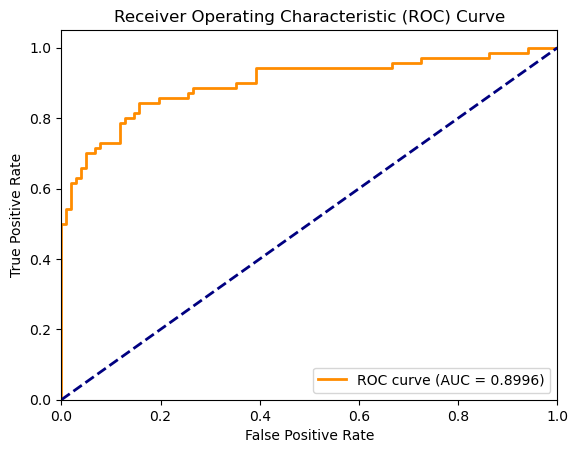

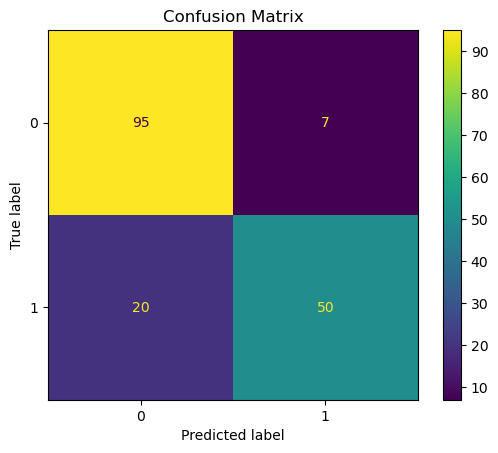

Original batch shape: torch.Size([4, 60, 1, 224, 224])
Augmented batch shape: torch.Size([4, 60, 1, 224, 224]) | Time: 0.0534
Num instances: 60


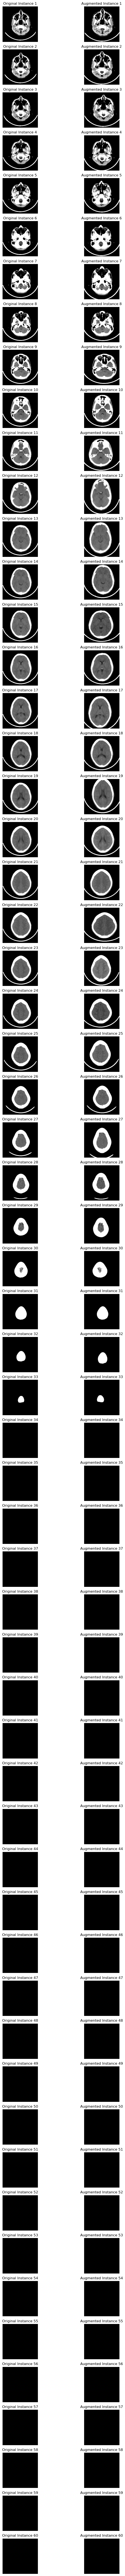

In [45]:
def main(mode='train'):
    os.environ["WANDB_DISABLED"] = "true"

    # Initialize W&B
    wandb.init(project="MIL_Resnet_ICH")
    
    # Log hyperparameters
    config = wandb.config
    config.learning_rate = LEARNING_RATE
    config.batch_size = TRAIN_BATCH_SIZE
    config.num_epochs = NUM_EPOCHS

    set_seed()
    train_labels, val_labels, test_labels = split_dataset(patient_scan_labels, test_size=TEST_SIZE)
    train_loader = get_train_loader(dicom_dir, train_labels, batch_size=TRAIN_BATCH_SIZE)
    val_loader = get_train_loader(dicom_dir, val_labels, batch_size=VALID_BATCH_SIZE)
    test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)

    set_seed()
    
    # Initialize model, criterion, and optimizer
    model = MILResNet18()
    # model = Encoder()
    
    criterion_cl = NTXentLoss(0.5)
    criterion_bce = torch.nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    if mode == 'train':
        # Watch the model to log gradients and parameters
        wandb.watch(model)

        # Train model
        trained_model = train_model(model, train_loader, val_loader, criterion_cl, criterion_bce, optimizer, config.num_epochs, config.learning_rate, DEVICE)

        # Save model
        torch.save(trained_model.state_dict(), MODEL_PATH)

    # Load best model
    # trained_model = load_model(Encoder, MODEL_PATH)
    trained_model = load_model(MILResNet18, MODEL_PATH)

    # Evaluate model
    predictions, labels = evaluate_model(trained_model, test_loader, DEVICE)
    metrics = calculate_metrics(predictions, labels)

    # Log metrics to W&B
    wandb.log(metrics)

    print_metrics(metrics)
    
    # if mode == 'train':
        # Visualizations
    plot_roc_curve(trained_model, test_loader, DEVICE)
    plot_confusion_matrix(trained_model, test_loader, DEVICE)

    if mode == 'train':
        required_columns = ['patient_id', 'study_instance_uid', 'patient_label']
        temp_test_labels = test_labels[required_columns]
        
        # Save results
        # results_df = get_test_results(trained_model, test_loader, temp_test_labels, device)
        # results_df.to_csv('results/results.csv', index=False)
        # print(results_df.head())

        # # Log results DataFrame as a table in W&B (optional)
        # wandb.log({"results": wandb.Table(dataframe=results_df)})

    # # Call the function with the test_loader
    # if isinstance(model, MILResNet18):
    #     test_loader = get_test_loader(dicom_dir, test_labels, batch_size=TEST_BATCH_SIZE)
    #     plot_label_attention_weights(trained_model, test_loader, device)
    
    # Get the first batch of images from the evaluation loader
    images, _, _ = next(iter(train_loader))
    print(f'Original batch shape: {images.shape}')
    
    # Augment the batch of images
    # Start timer 
    start = time.time()
    augmented_images = augment_batch(images)
    end = time.time()
    taken_time = end - start
    print(f'Augmented batch shape: {augmented_images.shape} | Time: {taken_time:.4f}')
    
    # Visualize the original and augmented bags
    visualize_augmented_bags(images, augmented_images)

if __name__ == "__main__":
    main(mode='train')

## Results